In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score,recall_score,make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import optuna
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
warnings.filterwarnings('ignore')

loan_df = pd.read_csv('loan.csv')
dict_df = pd.read_excel('Data_Dictionary.xlsx')

In [104]:
print(f"Shape of the dataset: {loan_df.shape}")
print(f"Type of dataset: {loan_df.dtypes}")

Shape of the dataset: (39717, 111)
Type of dataset: id                              int64
member_id                       int64
loan_amnt                       int64
funded_amnt                     int64
funded_amnt_inv               float64
                               ...   
tax_liens                     float64
tot_hi_cred_lim               float64
total_bal_ex_mort             float64
total_bc_limit                float64
total_il_high_credit_limit    float64
Length: 111, dtype: object


In [105]:
# Kiểm tra dòng trùng lặp
print(loan_df.duplicated(subset = None, keep = 'first').count())

# Sử dụng cột id để kiểm tra
duplicate_rows = loan_df[loan_df.duplicated(['id'])]
print("duplicate_rows :", duplicate_rows)

39717
duplicate_rows : Empty DataFrame
Columns: [id, member_id, loan_amnt, funded_amnt, funded_amnt_inv, term, int_rate, installment, grade, sub_grade, emp_title, emp_length, home_ownership, annual_inc, verification_status, issue_d, loan_status, pymnt_plan, url, desc, purpose, title, zip_code, addr_state, dti, delinq_2yrs, earliest_cr_line, inq_last_6mths, mths_since_last_delinq, mths_since_last_record, open_acc, pub_rec, revol_bal, revol_util, total_acc, initial_list_status, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, next_pymnt_d, last_credit_pull_d, collections_12_mths_ex_med, mths_since_last_major_derog, policy_code, application_type, annual_inc_joint, dti_joint, verification_status_joint, acc_now_delinq, tot_coll_amt, tot_cur_bal, open_acc_6m, open_il_6m, open_il_12m, open_il_24m, mths_since_rcnt_il, total_bal_il, il_util, open_rv_12m, open_rv_24m, ma

In [106]:
# Kiểm tra tổng số dòng trùng lặp
loan_df.duplicated().sum()

0

In [107]:
# Xóa các cột rỗng hoàn toàn
loan_df = loan_df.dropna(axis = 1, how = 'all')

In [108]:
# Tìm số lượng hàng có tất cả các giá trị là rỗng
print('Number of rows having all values as null:')
print(loan_df.isnull().all(axis = 1).sum())

# Tìm số lượng cột có tất cả các giá trị là rỗng
print('Number of columns having all values as null:')
print(loan_df.isnull().all(axis = 0).sum())

Number of rows having all values as null:
0
Number of columns having all values as null:
0


In [109]:
# In ra dữ liệu không nhất quán
numeric = loan_df.select_dtypes(include = np.number)
(numeric.values < 0).sum()

0

In [110]:
# Loại bỏ ký hiệu % trong cột 'int_rate' và 'revol_util' để thêm vào trong phân tích
loan_df['int_rate'] = loan_df['int_rate'].str.rstrip('%').astype(float)
loan_df['revol_util'] = loan_df['revol_util'].str.rstrip('%').astype(float)

- Loại bỏ ký hiệu % trong cột 'int_rate' và 'revol_util' do các cột 'int_rate' và 'revol_util' cần thiết cho việc huấn luyện mô hình.
- 'int_rate' là tỷ lệ lãi suất ngân hàng, lãi suất cao sẽ ảnh hưởng đến khả năng có trả nợ hay không. 
- 'revol_util' là tỷ lệ sử dụng nợ tín dụng, thể hiện khả năng tự mình trả nợ của khách hàng.

In [111]:
loan_df['emp_length'] = loan_df.emp_length.str.extract('(\d+)')
# Chuyển đổi các cột dữ liệu số thành kiểu numeric
columns1 = ['loan_amnt', 'funded_amnt', 'int_rate', 'funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'emp_length', 'total_pymnt']
loan_df[columns1] = loan_df[columns1].apply(pd.to_numeric)

In [112]:
# Loại bỏ giá trị 'Current' trong cột 'loan_status' do vẫn còn trong thời hạn mượn nợ
loan_df = loan_df[loan_df.loan_status != "Current"]

- Do cột 'loan_status' sẽ được sử dụng làm target để xác định có nên đồng thuận khoản vay đó hay không, ta nên tập trung vào việc người đó trả hết nợ hoặc không có khả năng trả để từ đó dự đoán.

In [113]:
loan_df.loan_status.value_counts()

loan_status
Fully Paid     32950
Charged Off     5627
Name: count, dtype: int64

In [114]:
# Điền giá trị 0 cho các dòng Null trong cột 'pub_rec_bankruptcies'
loan_df['pub_rec_bankruptcies'].fillna(0, inplace = True)

# Kiểm tra số lượng giá trị Null trong cột 'pub_rec_bankruptcies'
loan_df['pub_rec_bankruptcies'].isnull().sum()

0

In [115]:
# Tính tỷ lệ giá trị thiếu cho mỗi cột
missing_values = loan_df.isnull().mean() * 100

# Xác định các cột có tỷ lệ giá trị thiếu lớn hơn 10%
cols_to_drop = missing_values[missing_values > 10].index

# Xóa các cột này khỏi DataFrame
loan_df = loan_df.drop(columns = cols_to_drop)

# Hiển thị các cột đã bị xóa
print(f"Deleted cols: {cols_to_drop.tolist()}")

Deleted cols: ['desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d']


- Xóa các cột ['desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d'] do các dữ liệu Null được dự đoán bởi thuật toán MICE không đáng tin vì chứa nhiều missing value. 

In [116]:
# Sử dụng IterativeImputer để điền các giá trị Null
imputer = IterativeImputer(random_state = 100, max_iter = 10)
df2 = loan_df.select_dtypes(exclude = 'object')
imputer.fit(df2)
df_imputed = imputer.transform(df2)
df_imputed[:10]
df_imputed = pd.DataFrame(df_imputed, columns = df2.columns)
df = loan_df.drop(columns = df2.columns)
loan_df = pd.concat([df_imputed, df], axis = 1)

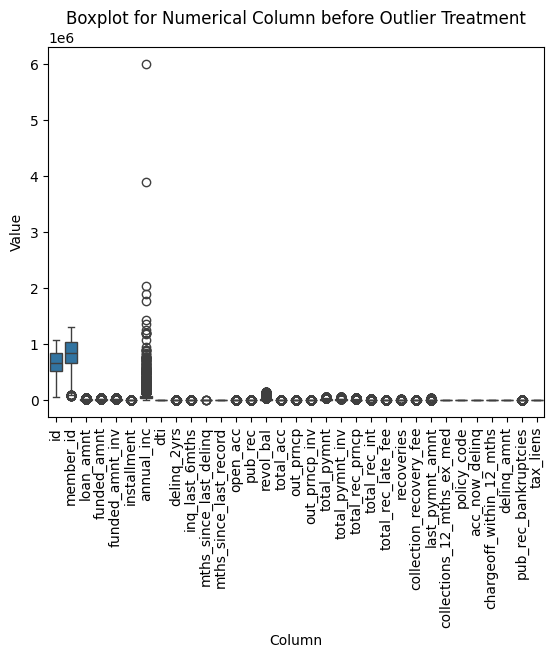

In [117]:
# Vẽ biểu đồ boxplot thể hiện các giá trị ngoại lai
numeric = pd.melt(numeric, var_name = 'Column', value_name = 'Value')
sns.boxplot(data=numeric, x = 'Column', y = 'Value')
plt.title("Boxplot for Numerical Column before Outlier Treatment")
plt.xticks(rotation = 90)
plt.show()

In [118]:
# Hàm loại bỏ các giá trị ngoại lai
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Tính các khoảng giới hạn
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Xóa các dòng có giá trị nằm ngoài khoảng
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df_cleaned

In [119]:
# Do cột 'annual_inc' có nhiều giá trị ngoại lai nên ta sẽ remove
loan_df = remove_outliers(loan_df, 'annual_inc')

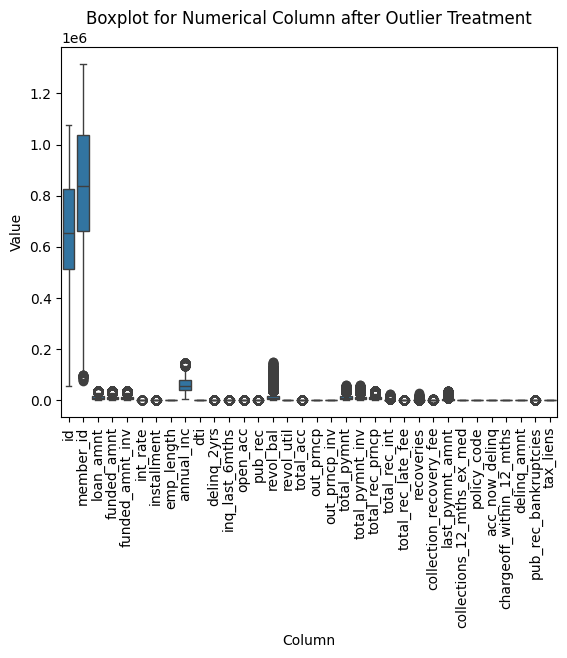

In [120]:
numeric = pd.melt(loan_df.select_dtypes(exclude = 'object'), var_name = 'Column', value_name = 'Value')
sns.boxplot(data = numeric, x = 'Column', y = 'Value')
plt.title("Boxplot for Numerical Column after Outlier Treatment")
plt.xticks(rotation = 90)
plt.show()

In [121]:
loan_df.describe()

id     member_id     loan_amnt   funded_amnt  \
count  3.681500e+04  3.681500e+04  36815.000000  36815.000000   
mean   6.760857e+05  8.419800e+05  10706.984925  10460.175200   
std    2.091882e+05  2.643366e+05   7068.107909   6820.737715   
min    5.473400e+04  7.472400e+04    500.000000    500.000000   
25%    5.122775e+05  6.614220e+05   5000.000000   5000.000000   
50%    6.556460e+05  8.378840e+05   9250.000000   9000.000000   
75%    8.278755e+05  1.035967e+06  15000.000000  14400.000000   
max    1.077501e+06  1.314167e+06  35000.000000  35000.000000   

       funded_amnt_inv      int_rate   installment    emp_length  \
count     36815.000000  36815.000000  36815.000000  36815.000000   
mean       9916.487115     11.889882    312.593015      5.026362   
std        6750.340900      3.668709    199.806808      3.347519   
min           0.000000      5.420000     15.690000      1.000000   
25%        4988.984523      8.940000    163.305000      2.000000   
50%        8400.000000     11.710000    271.140000      4.000000   
75%       13687.858570     14.270000    409.700000      8.000000   
max       35000.000000     24.400000   1305.190000     10.000000   

          annual_inc           dti  ...    recoveries  \
count   36815.000000  36815.000000  ...  36815.000000   
mean    61218.193490     13.437614  ...     95.148365   
std     28224.583784      6.660651  ...    680.688516   
min      4000.000000      0.000000  ...      0.000000   
25%     40000.000000      8.340000  ...      0.000000   
50%     56000.000000     13.570000  ...      0.000000   
75%     78000.000000     18.700000  ...      0.000000   
max    145000.000000     29.990000  ...  29623.350000   

       collection_recovery_fee  last_pymnt_amnt  collections_12_mths_ex_med  \
count             36815.000000     36815.000000                     36815.0   
mean                 12.176062      2634.677276                         0.0   
std                 145.441890      4313.178379                         0.0   
min                   0.000000         0.000000                         0.0   
25%                   0.000000       212.730000                         0.0   
50%                   0.000000       546.160000                         0.0   
75%                   0.000000      3312.680000                         0.0   
max                7002.190000     36115.200000                         0.0   

       policy_code  acc_now_delinq  chargeoff_within_12_mths  delinq_amnt  \
count      36815.0         36815.0                   36815.0      36815.0   
mean           1.0             0.0                       0.0          0.0   
std            0.0             0.0                       0.0          0.0   
min            1.0             0.0                       0.0          0.0   
25%            1.0             0.0                       0.0          0.0   
50%            1.0             0.0                       0.0          0.0   
75%            1.0             0.0                       0.0          0.0   
max            1.0             0.0                       0.0          0.0   

       pub_rec_bankruptcies  tax_liens  
count          36815.000000    36815.0  
mean               0.043787        0.0  
std                0.205285        0.0  
min                0.000000        0.0  
25%                0.000000        0.0  
50%                0.000000        0.0  
75%                0.000000        0.0  
max                2.000000        0.0  

[8 rows x 34 columns]

In [122]:
# Tính phần trăm dựa vào mục đích vay
(loan_df.purpose.value_counts() * 100) / len(loan_df)

purpose
debt_consolidation    45.476029
credit_card           12.614423
other                  9.542306
home_improvement       7.266060
major_purchase         5.508624
small_business         4.400380
car                    3.805514
wedding                2.319707
medical                1.727557
moving                 1.469510
vacation               0.947983
house                  0.947983
educational            0.752411
renewable_energy       0.258047
Name: count, dtype: float64

In [123]:
# Bỏ các cột dưới đây vì các dữ liệu không ảnh hưởng đến việc dự đoán
columns_to_drop = ["id", "member_id", "application_type", "policy_code", "initial_list_status", "installment", "pymnt_plan", "addr_state", "grade", "url", "collections_12_mths_ex_med", "acc_now_delinq"]
loan_df = loan_df.drop(columns = [col for col in columns_to_drop if col in loan_df.columns])

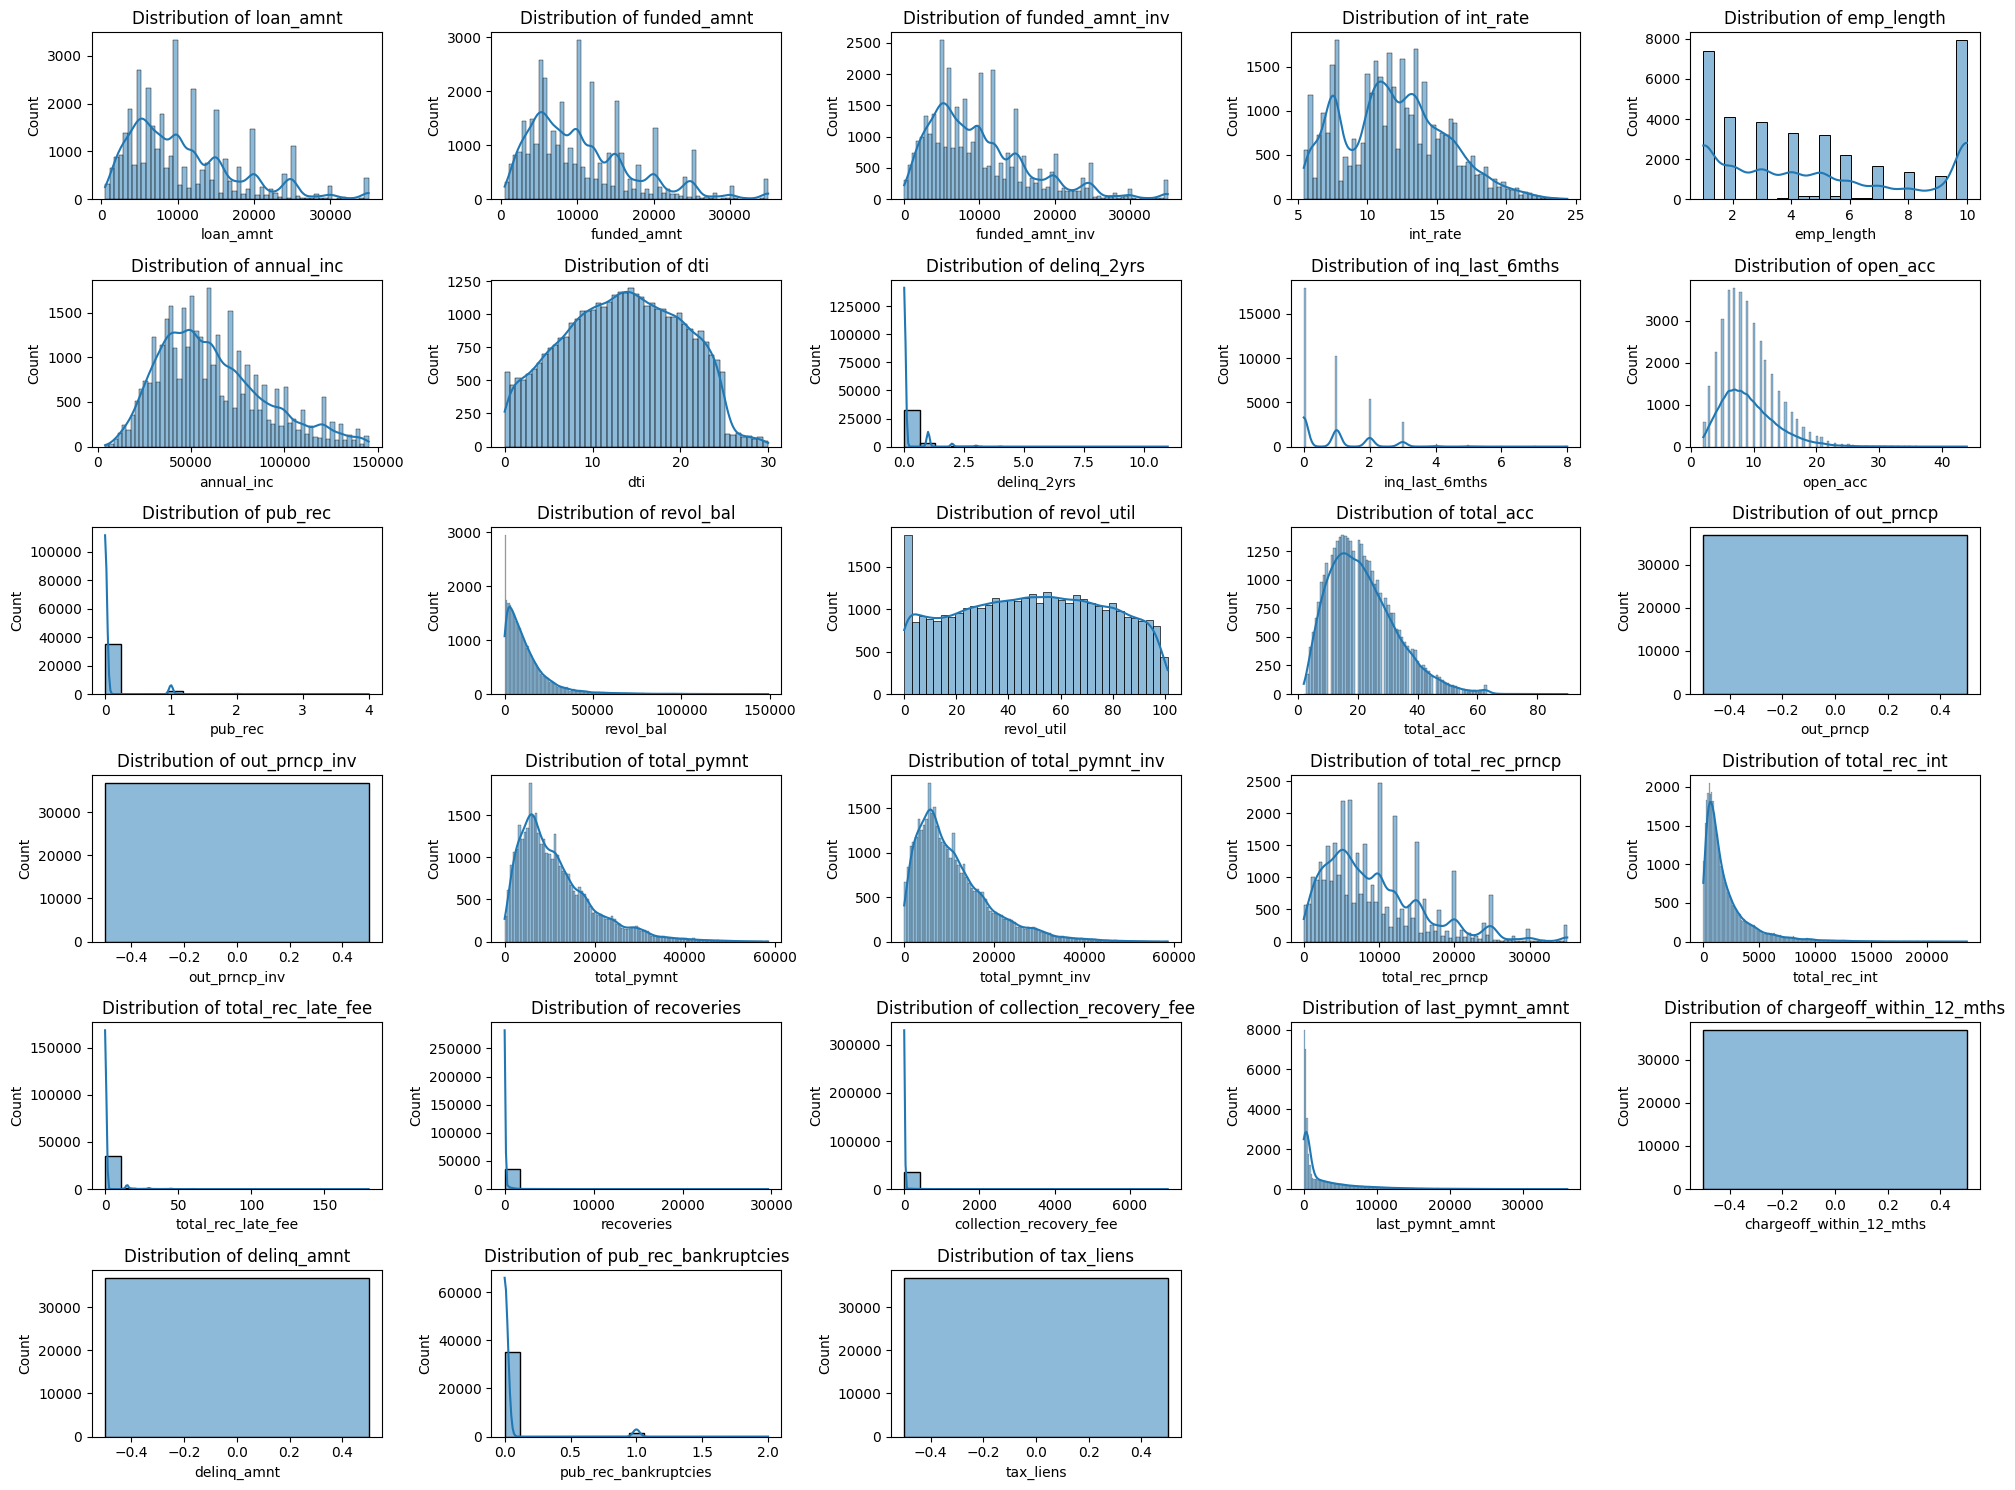

In [124]:
numerical_features = loan_df.select_dtypes(exclude = 'object').columns
# Vẽ đồ thị phân phối của các biến số
num_features = len(numerical_features)
num_cols = 5
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)

plt.figure(figsize = (20, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(loan_df[feature], kde = True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

In [125]:
# Bỏ các cột dưới đây vì các giá trị không đổi
columns_to_drop = ['out_prncp', 'out_prncp_inv', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens']
loan_df = loan_df.drop(columns = [col for col in columns_to_drop if col in loan_df.columns])

- Bỏ các cột trên vì các giá trị không đổi nên không ảnh hưởng đến dự đoán mô hình.

In [126]:
# Tiến hành Label encoding
label_encoder = LabelEncoder()
binary_cols = loan_df.select_dtypes(include=['object']).columns.intersection(['term', 'sub_grade', 'home_ownership', 
                                                                             'verification_status', 'issue_d',
                                                                             'purpose', 'title', 'zip_code', 
                                                                             'earliest_cr_line',
                                                                             'last_pymnt_d', 'last_credit_pull_d', 'emp_title'])
for col in binary_cols:
    loan_df[col] = label_encoder.fit_transform(loan_df[col])

for col in binary_cols:
    freq_encoding = loan_df[col].value_counts().to_dict()
    loan_df[col] = loan_df[col].map(freq_encoding)

- Thay giá trị 'Fully Paid' = 1, 'Charged Off' = 0 do nếu 1 người trả nợ thì có thể tiếp tục cho mượn và ngược lại.
- Nên lấy loan_status làm cột target cho model.

In [127]:
loan_df['loan_status'] = loan_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})

In [128]:
# Điền các giá trị trống bằng giá trị median
loan_df = loan_df.fillna(loan_df.median())

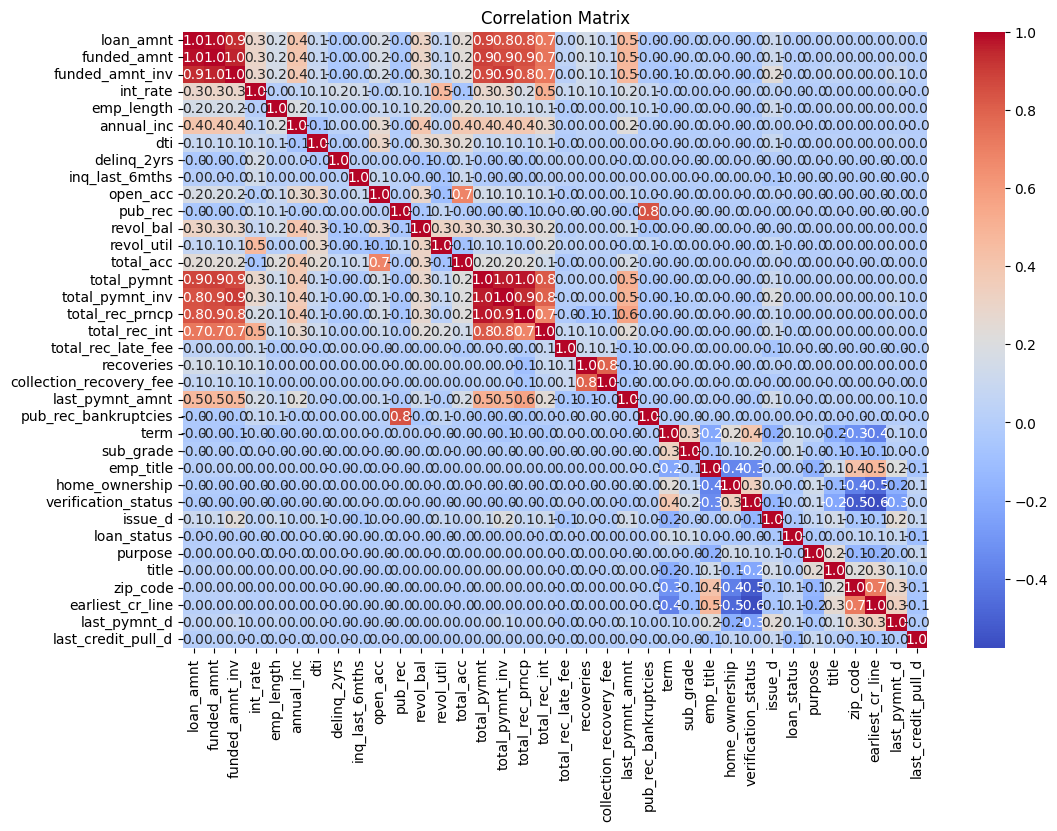

In [129]:
# Giả dụ cột 'loan_status' sẽ chỉ ra rằng khoản vay được chấp nhận hay không
# Mã hóa các giá trị biến trong 'loan_status'
loan_df['loan_status'] = loan_df['loan_status'].apply(lambda x: 1 if x == 1.0 else 0)

# Tính ma trận tương quan
correlation_matrix = loan_df.corr()

# Vẽ đồ thị heatmap cho ma trận tương quan
plt.figure(figsize = (12, 8))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = '.1f')
plt.title('Correlation Matrix')
plt.show()

- Từ hình ta thấy được sự tương quan giữa các feature với nhau, các feature có sự tương quan lớn nên có loại bỏ được 1 trong 2.

In [130]:
# Loại bỏ các cột có độ tương quan cao
columns_to_drop = ['funded_amnt_inv', 'total_pymnt_inv', 'issue_d']
loan_df = loan_df.drop(columns = [col for col in columns_to_drop if col in loan_df.columns])

Class Distribution of Loan Status:
loan_status
1    31627
0     5188
Name: count, dtype: int64


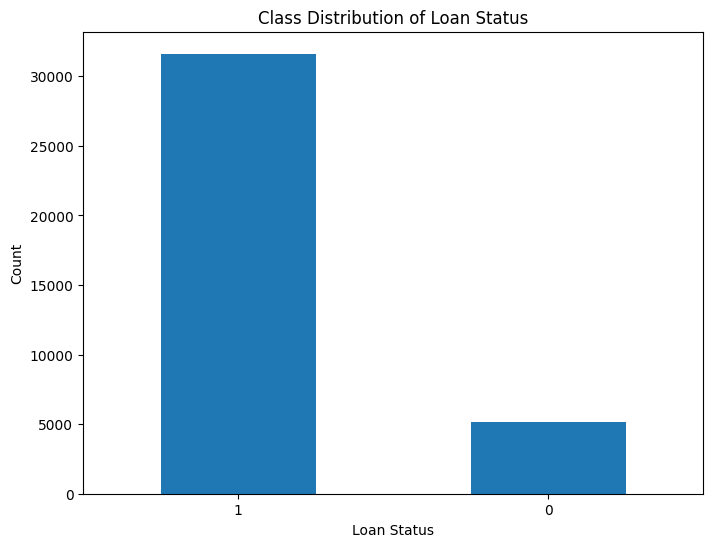

In [131]:
# Đếm các giá trị khác nhau trong 'loan_status'
loan_status_counts = loan_df['loan_status'].value_counts()

print("Class Distribution of Loan Status:")
print(loan_status_counts)

# Vẽ đồ thị phân phối cho từng lớp
plt.figure(figsize = (8, 6))
loan_status_counts.plot(kind = 'bar')
plt.title('Class Distribution of Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

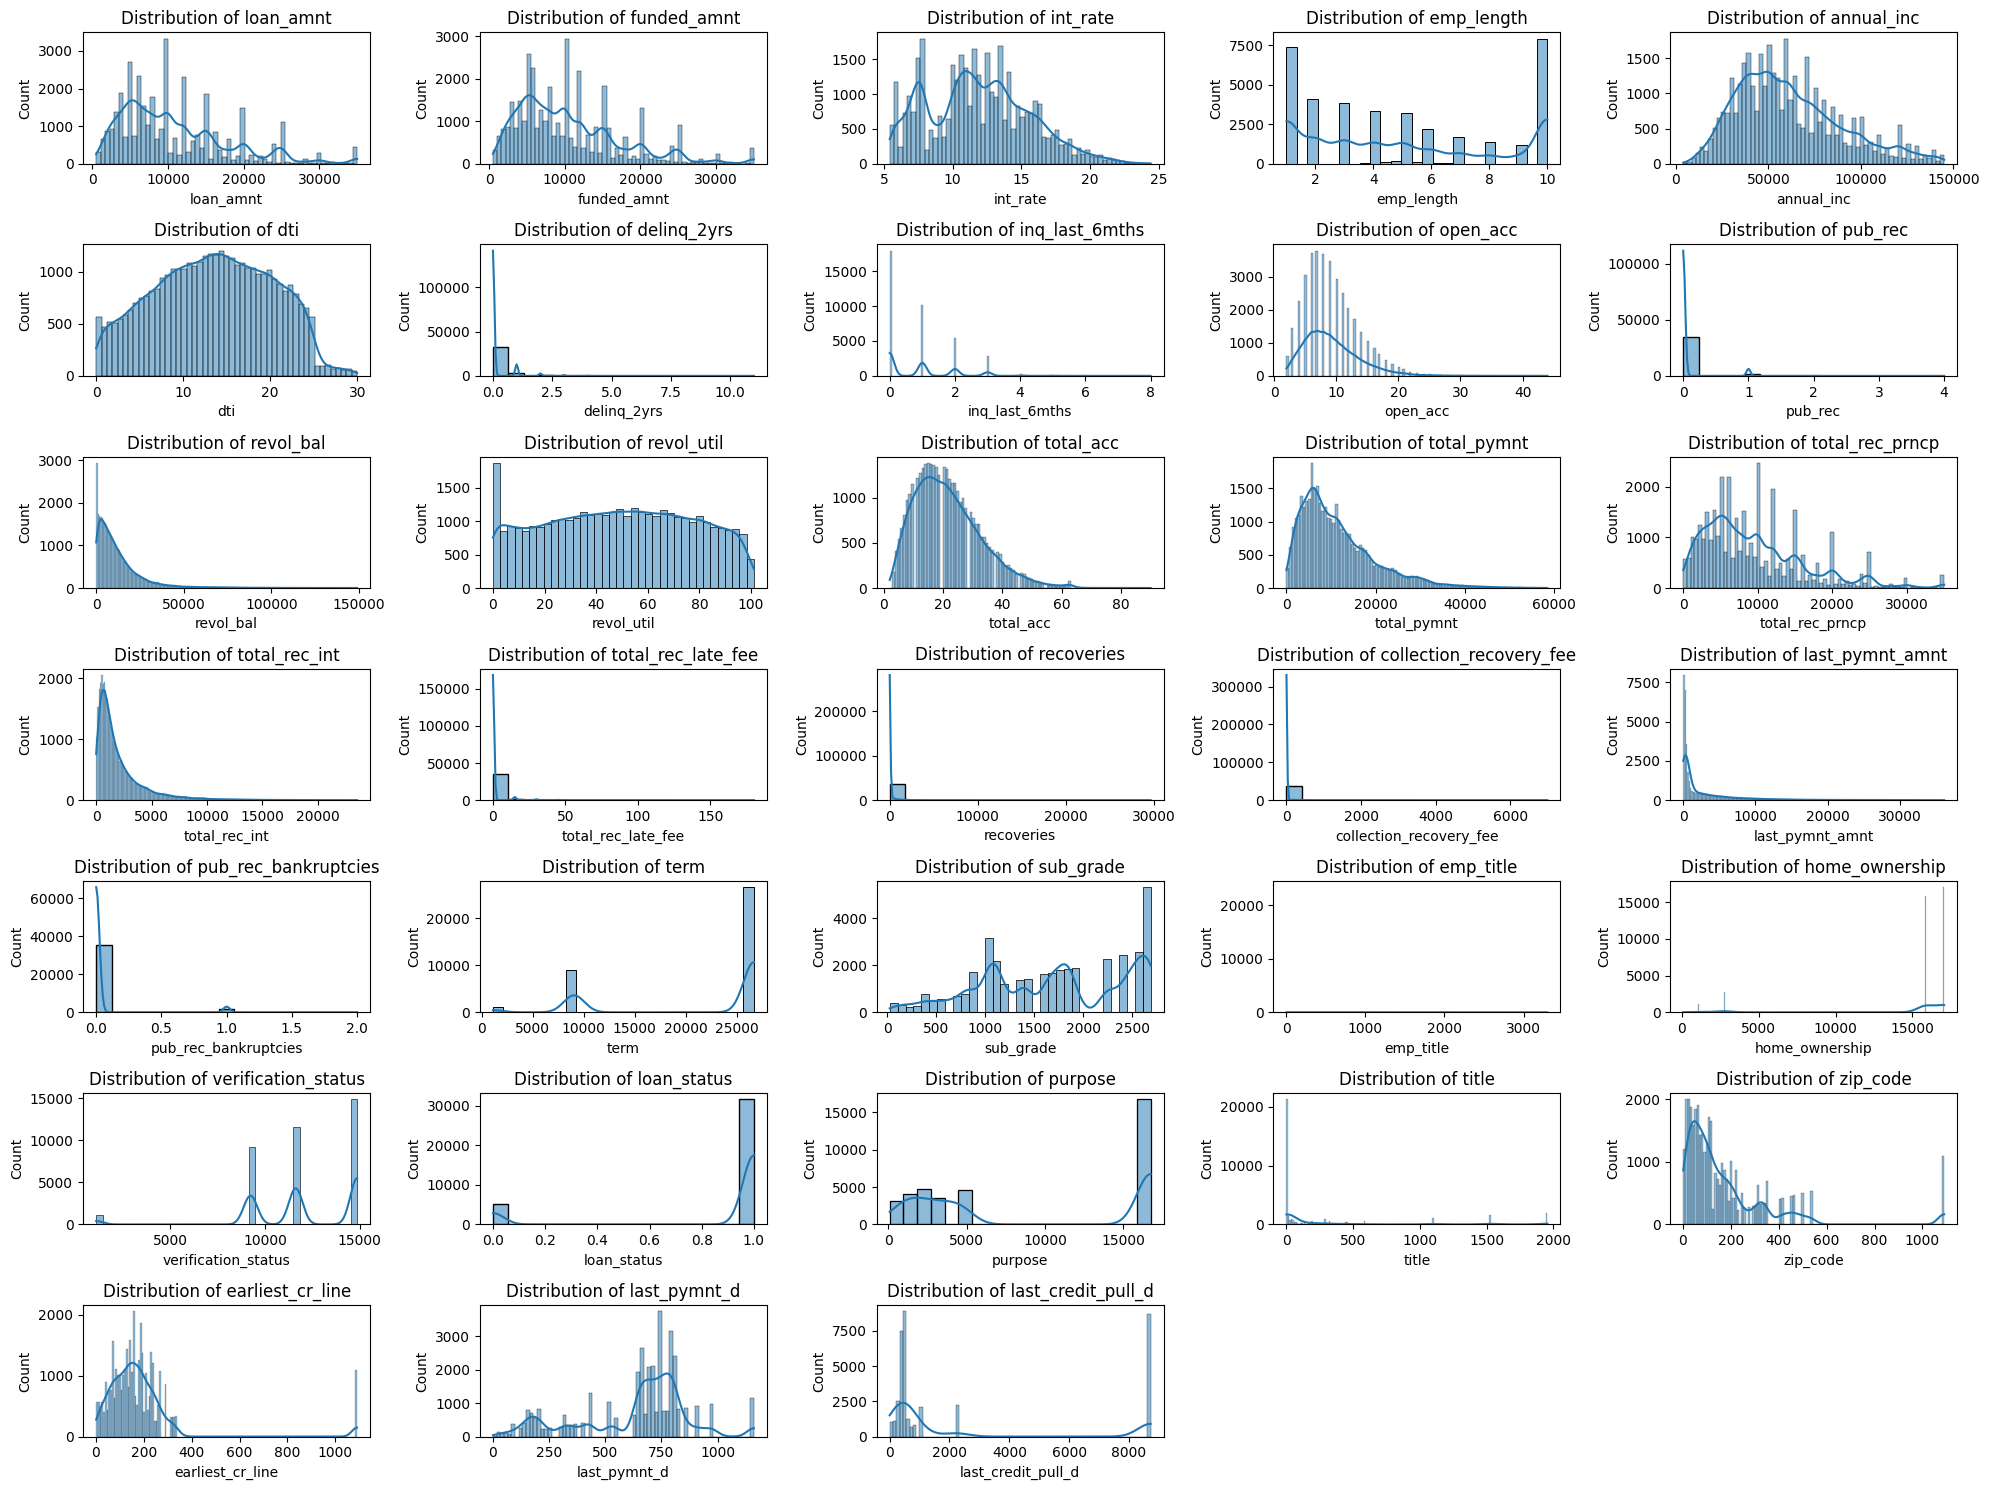

In [ ]:
numerical_features = loan_df

# Vẽ đồ thị phân phối cho các feature
num_features = len(numerical_features)
num_cols = 5
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)

plt.figure(figsize = (20, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(loan_df[feature], kde = True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show() 

1. **Class Distribution**:
   - Analyze the balance of accepted vs. rejected loans được thực hiện bằng cách đếm số lần xuất hiện của Fully paid và Charged off.
   - Vẽ biểu đồ cột để trực quan hóa loan_status.

2. **Feature Distributions**:
   - Vẽ các biểu đồ cột thể hiện sự phân bố dữ liệu của từng feature. Từ đó, tập trung vào các feature có mật độ phân bố trải đều, ổn định như: dti, annual_inc, total_pymnt, total_acc...

3. **Correlation Analysis**:
   - Vẽ biểu đồ nhiệt để thể hiện sự tương quan của features qua correlation matrix, loại bỏ các feature có độ tương quan lớn.

4. **Missing Values**:
   - Dựa vào phần trăm các giá trị bị thiếu để lựa chọn feature phù hợp cho mô hình. 
   - Giữ lại các feature có phần trăm thiếu sót dưới 10% do các feature có ít sự liên kết với nhau.
   - Điền các giá trị thiếu bằng 2 cách:
      - Đối với numeric_features: sử dụng mô hình MICE để dự đoán.
      - Đối với categorical variables: encoding dữ liệu sau đó điền giá trị bị thiếu bằng median.

In [133]:
# Tạo StandardScaler để chuẩn hóa dữ liệu
ss = StandardScaler()

# Chuẩn hóa dữ liệu
loan_df_scaled = ss.fit_transform(loan_df.select_dtypes(exclude= 'object'))

In [135]:
# Chuẩn bị dữ liệu
X = loan_df.drop(columns=['loan_status'])  # Features
y = loan_df['loan_status']  # Target

# Tách dữ liệu để huấn luyện
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

II Model Development

Decision Tree

In [ ]:
# Create the Decision Tree model with class weight to minimize false positives
dt_model = DecisionTreeClassifier(class_weight = 'balanced', random_state = 42)

# Train the model
dt_model.fit(X_train, y_train)

y_val_pred = dt_model.predict(X_val)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))

Confusion Matrix:
[[ 245  475]
 [ 500 3934]]

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.34      0.33       720
           1       0.89      0.89      0.89      4434

    accuracy                           0.81      5154
   macro avg       0.61      0.61      0.61      5154
weighted avg       0.81      0.81      0.81      5154


Accuracy Score:
0.810826542491269
ROC AUC Score:
0.6137563900165388


In [893]:
# Predict on the validation set
y_test_pred = dt_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_test_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_test_pred))

Confusion Matrix:
[[ 512 1051]
 [1091 8391]]

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.33      0.32      1563
           1       0.89      0.88      0.89      9482

    accuracy                           0.81     11045
   macro avg       0.60      0.61      0.61     11045
weighted avg       0.81      0.81      0.81     11045


Accuracy Score:
0.8060660932548664
ROC AUC Score:
0.6062575310218384


HyperTunning

In [894]:
# Hàm mục tiêu
def objective(trial):
    # Tham số để tối ưu hóa
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    
    # Mô hình Decision Tree
    dt_model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42,
        class_weight='balanced'
    )

    # Tính Recall của lớp 0 với Cross-Validation
    recall_scores = cross_val_score(
        dt_model, X_train, y_train, 
        cv=5, scoring=make_scorer(recall_score, pos_label=0)
    )
    
    # Trả về Recall trung bình
    return recall_scores.mean()

In [895]:
study = optuna.create_study(direction='maximize')  # Tối đa hóa Recall lớp 0
study.optimize(objective, n_trials=50)  # Thử nghiệm 50 lần

# Kết quả tốt nhất
print("Best parameters:", study.best_params)
print("Best recall for class 0:", study.best_value)

[I 2024-11-28 01:09:00,349] A new study created in memory with name: no-name-f5dba3b4-bf8a-45c4-a53c-0c4ec408af06
[I 2024-11-28 01:09:03,073] Trial 0 finished with value: 0.534251290877797 and parameters: {'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 0 with value: 0.534251290877797.
[I 2024-11-28 01:09:03,869] Trial 1 finished with value: 0.646815834767642 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 1 with value: 0.646815834767642.
[I 2024-11-28 01:09:05,957] Trial 2 finished with value: 0.5476764199655766 and parameters: {'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 1 with value: 0.646815834767642.
[I 2024-11-28 01:09:07,767] Trial 3 finished with value: 0.6017211703958691 and parameters: {'max_depth': 12, 'min_samples_split': 14, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 1 with valu

Best parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy'}
Best recall for class 0: 0.646815834767642


In [896]:
best_params = study.best_params
dt_model = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    criterion=best_params['criterion'],
    class_weight='balanced',
    random_state=42
)

dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, random_state=42)

In [897]:
y_train_pred = dt_model.predict(X_train)
print("Train Set:")
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred))

Train Set:
Confusion Matrix:
[[ 1899  1006]
 [ 4967 12744]]

Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.65      0.39      2905
           1       0.93      0.72      0.81     17711

    accuracy                           0.71     20616
   macro avg       0.60      0.69      0.60     20616
weighted avg       0.84      0.71      0.75     20616



In [ ]:
# Predict on the validation set
y_val_pred = dt_model.predict(X_val)
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))
# Predict on the test set
y_test_pred = dt_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_test_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_test_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.65      0.39       720
           1       0.93      0.72      0.81      4434

    accuracy                           0.71      5154
   macro avg       0.60      0.69      0.60      5154
weighted avg       0.84      0.71      0.75      5154


Accuracy Score:
0.7120682964687621
ROC AUC Score:
0.6854918433318299

Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.64      0.39      1563
           1       0.92      0.72      0.81      9482

    accuracy                           0.71     11045
   macro avg       0.60      0.68      0.60     11045
weighted avg       0.83      0.71      0.75     11045


Accuracy Score:
0.7112720688094161
ROC AUC Score:
0.6816919028855293


Feature Selection

In [ ]:
# Lấy trọng số của từng feature
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_model.feature_importances_
}).sort_values(by = 'Importance', ascending = False)
# Hiển thị các đặc trưng quan trọng
print("Feature Importances:")
print(feature_importances.head(20))


Feature Importances:
                    Feature  Importance
30             last_pymnt_d    0.439236
21                     term    0.283483
22                sub_grade    0.241104
31       last_credit_pull_d    0.028540
2                  int_rate    0.007637
17               recoveries    0.000000
29         earliest_cr_line    0.000000
28                 zip_code    0.000000
27                    title    0.000000
26                  purpose    0.000000
25      verification_status    0.000000
24           home_ownership    0.000000
23                emp_title    0.000000
20     pub_rec_bankruptcies    0.000000
19          last_pymnt_amnt    0.000000
18  collection_recovery_fee    0.000000
0                 loan_amnt    0.000000
1               funded_amnt    0.000000
15            total_rec_int    0.000000
14          total_rec_prncp    0.000000


In [ ]:
threshold = 0.03
selected_features = feature_importances[feature_importances['Importance'] > threshold]
selected_features

Feature  Importance
30  last_pymnt_d    0.439236
21          term    0.283483
22     sub_grade    0.241104

In [901]:
# Lấy danh sách các feature từ selected_features
selected_feature_names = selected_features['Feature'].tolist()

# Lọc X_train chỉ giữ lại các feature trong selected_feature_names
X_train_selected = X_train[selected_feature_names]
X_val_selected = X_val[selected_feature_names]
X_test_selected = X_test[selected_feature_names]

# Hiển thị các cột đã được chọn
print(X_train_selected.columns)

Index(['last_pymnt_d', 'term', 'sub_grade'], dtype='object')


In [902]:
# Train the model
dt_model.fit(X_train_selected, y_train)

y_val_pred = dt_model.predict(X_val_selected)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))

Confusion Matrix:
[[ 469  251]
 [1201 3233]]

Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.65      0.39       720
           1       0.93      0.73      0.82      4434

    accuracy                           0.72      5154
   macro avg       0.60      0.69      0.60      5154
weighted avg       0.84      0.72      0.76      5154


Accuracy Score:
0.7182770663562281
ROC AUC Score:
0.6902636821530597


In [903]:
y_test_pred = dt_model.predict(X_test_selected)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_test_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_test_pred))

Confusion Matrix:
[[ 993  570]
 [2568 6914]]

Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.64      0.39      1563
           1       0.92      0.73      0.82      9482

    accuracy                           0.72     11045
   macro avg       0.60      0.68      0.60     11045
weighted avg       0.83      0.72      0.75     11045


Accuracy Score:
0.7158895427795382
ROC AUC Score:
0.682243879807017


Logistic Regression Model

In [ ]:
logistic_model = LogisticRegression(class_weight = 'balanced', random_state = 42, penalty = 'l2', solver = 'liblinear')

logistic_model.fit(X_train, y_train)

y_val_pred = logistic_model.predict(X_val)
print("Validation Set:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))

Validation Set:
Confusion Matrix:
[[ 449  271]
 [1480 2954]]

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.62      0.34       720
           1       0.92      0.67      0.77      4434

    accuracy                           0.66      5154
   macro avg       0.57      0.64      0.56      5154
weighted avg       0.82      0.66      0.71      5154


Accuracy Score:
0.6602638727202174
ROC AUC Score:
0.6449133588933995


HyperTunning

In [905]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300],
    'class_weight': ['balanced']
}

In [ ]:
# Tạo đối tượng LogisticRegression
model = LogisticRegression()

# Sử dụng GridSearchCV để tìm các tham số tốt nhất
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, scoring = make_scorer(recall_score, pos_label = 0), cv = 5, n_jobs = -1)

# Huấn luyện mô hình
grid_search.fit(X_train, y_train)

# In ra các tham số tốt nhất
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


In [907]:
# Dự đoán và đánh giá mô hình
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.61      0.34      1563
           1       0.91      0.67      0.77      9482

    accuracy                           0.66     11045
   macro avg       0.57      0.64      0.56     11045
weighted avg       0.82      0.66      0.71     11045

Accuracy Score:
0.6636487098234495
ROC AUC Score:
0.6427341605463724


In [908]:
y_val_pred = best_model.predict(X_val)

# Evaluate the model
print("Validation Set:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))

Validation Set:
Confusion Matrix:
[[ 450  270]
 [1454 2980]]

Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.62      0.34       720
           1       0.92      0.67      0.78      4434

    accuracy                           0.67      5154
   macro avg       0.58      0.65      0.56      5154
weighted avg       0.82      0.67      0.72      5154


Accuracy Score:
0.6655025223127667
ROC AUC Score:
0.6485396932792062


Feature Selection

In [ ]:
weights = logistic_model.coef_[0]

# Tạo DataFrame chứa các feature và trọng số tương ứng
weights_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Weight': weights
})

# Sắp xếp theo trọng số giảm dần
weights_df = weights_df.sort_values(by = 'Weight', ascending = False)

# Hiển thị các feature quan trọng
print("Feature Weights:")
print(weights_df.head(20))

Feature Weights:
                 Feature        Weight
20  pub_rec_bankruptcies  2.035304e-02
9                pub_rec  1.720707e-02
16    total_rec_late_fee  4.249955e-03
29      earliest_cr_line  1.349613e-03
13           total_pymnt  1.088818e-03
28              zip_code  7.622478e-04
30          last_pymnt_d  4.589855e-04
22             sub_grade  3.470004e-04
21                  term  4.284772e-05
0              loan_amnt  4.136840e-05
27                 title  3.938881e-05
19       last_pymnt_amnt  1.693857e-05
10             revol_bal  3.896663e-06
4             annual_inc  3.039992e-07
26               purpose -5.609434e-06
24        home_ownership -3.044103e-05
25   verification_status -4.976498e-05
1            funded_amnt -4.996174e-05
31    last_credit_pull_d -7.507040e-05
23             emp_title -1.418517e-04


In [910]:
feature_weights = logistic_model.coef_[0]

# Chọn đặc trưng có trọng số lớn (chẳng hạn chỉ chọn những đặc trưng có trọng số > 0)
selected_features = np.abs(feature_weights) > 1e-5  # Ngưỡng có thể thay đổi

# Chọn ra X_train_selected
X_train_selected = X_train.loc[:, selected_features]

# In ra các đặc trưng được chọn
print("Selected Features:", X_train.columns[selected_features])

# In ra X_train_selected
print("X_train_selected shape:", X_train_selected.shape)

Selected Features: Index(['loan_amnt', 'funded_amnt', 'int_rate', 'emp_length', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util',
       'total_acc', 'total_pymnt', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'pub_rec_bankruptcies', 'term', 'sub_grade',
       'emp_title', 'home_ownership', 'verification_status', 'title',
       'zip_code', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'],
      dtype='object')
X_train_selected shape: (20616, 29)


In [911]:
X_val_selected = X_val.loc[:, selected_features]
X_test_selected = X_test.loc[:, selected_features]

In [912]:
best_model.fit(X_train_selected, y_train)

y_val_pred = best_model.predict(X_val_selected)

# Evaluate the model
print("Validation Set:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))

Validation Set:
Confusion Matrix:
[[ 451  269]
 [1455 2979]]

Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.63      0.34       720
           1       0.92      0.67      0.78      4434

    accuracy                           0.67      5154
   macro avg       0.58      0.65      0.56      5154
weighted avg       0.82      0.67      0.72      5154


Accuracy Score:
0.6655025223127667
ROC AUC Score:
0.6491213727259058


Pytorch

In [913]:
# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype = torch.long)  # Use long type for CrossEntropyLoss
X_val_tensor = torch.tensor(X_val, dtype = torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype = torch.long)  # Use long type for CrossEntropyLoss

In [915]:
# Chuyển đổi dữ liệu sang GPU
X_train_tensor = X_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

In [916]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [917]:
# Khởi tạo mô hình
input_size = X_train.shape[1]
hidden_size = 64
num_classes = len(y_train.unique())
model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)

In [ ]:

class_weights = torch.tensor([6.0, 1.0], dtype = torch.float32).to(device) # Tăng trọng số cho lớp 0 lên 6 lần so với lớp 1

# Chuyển criterion sang GPU
criterion = nn.CrossEntropyLoss(weight = class_weights).to(device)

# Khởi tạo optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001)


In [ ]:
# Huấn luyện mô hình
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch + 1} / {num_epochs}], Loss: {loss.item():.4f}')
        print("Recall Score: ", recall_score(y_train, model(X_train_tensor).argmax(dim = 1).cpu().detach().numpy(), pos_label = 0))


Epoch [10/100], Loss: 0.6869
Recall Score:  0.5328743545611015
Epoch [20/100], Loss: 0.6677
Recall Score:  0.563855421686747
Epoch [30/100], Loss: 0.6534
Recall Score:  0.6037865748709123
Epoch [40/100], Loss: 0.6423
Recall Score:  0.6230636833046471
Epoch [50/100], Loss: 0.6339
Recall Score:  0.6333907056798623
Epoch [60/100], Loss: 0.6276
Recall Score:  0.63407917383821
Epoch [70/100], Loss: 0.6225
Recall Score:  0.6333907056798623
Epoch [80/100], Loss: 0.6180
Recall Score:  0.6327022375215147
Epoch [90/100], Loss: 0.6136
Recall Score:  0.6354561101549053
Epoch [100/100], Loss: 0.6091
Recall Score:  0.6395869191049914


In [ ]:
# Đánh giá mô hình
# Dự đoán trên tập kiểm tra
model.eval()
with torch.no_grad():
    outputs = model(X_val_tensor)
    _, predicted = torch.max(outputs.data, 1)

# Chuyển đổi tensor thành numpy array
y_val_np = y_val_tensor.cpu().numpy()
predicted = predicted.cpu().numpy()

# Đánh giá mô hình
print("Confusion Matrix:")
print(confusion_matrix(y_val_np, predicted))
print("\nClassification Report:")
print(classification_report(y_val_np, predicted))
print("\nAccuracy Score:")
print(accuracy_score(y_val_np, predicted))
print("\nRecall Score for class 0:")
print(recall_score(y_val_np, predicted, pos_label = 0))

Confusion Matrix:
[[ 437  283]
 [1358 3076]]

Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.61      0.35       720
           1       0.92      0.69      0.79      4434

    accuracy                           0.68      5154
   macro avg       0.58      0.65      0.57      5154
weighted avg       0.82      0.68      0.73      5154


Accuracy Score:
0.6816065192083819

Recall Score for class 0:
0.6069444444444444


In [ ]:
#Model Evaluation
X_test = scaler.transform(X_test)
# Predict on the test set
X_test_tensor = torch.tensor(X_test, dtype = torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype = torch.long).to(device)

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)

# Convert the tensors to numpy arrays
y_test_np = y_test_tensor.cpu().numpy()
predicted = predicted.cpu().numpy()

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test_np, predicted))
print("\nClassification Report:")
print(classification_report(y_test_np, predicted))
print("\nAccuracy Score:")
print(accuracy_score(y_test_np, predicted))
print("\nROC AUC Score:") 
print(roc_auc_score(y_test_np, predicted))

Confusion Matrix:
[[ 942  621]
 [2846 6636]]

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.60      0.35      1563
           1       0.91      0.70      0.79      9482

    accuracy                           0.69     11045
   macro avg       0.58      0.65      0.57     11045
weighted avg       0.82      0.69      0.73     11045


Accuracy Score:
0.6861023087369851

ROC AUC Score:
0.6512697459698364


HyperTunning for Pytorch

In [922]:
# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

In [ ]:
def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    hidden_size = trial.suggest_int('hidden_size', 32, 256, step = 32)
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [32, 64]) #Do máy tính không đủ tài nguyên nên chỉ chọn 2 giá trị
    num_epochs = 10 

    # Initialize model with hyperparameters
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

    # Initialize model, loss, and optimizer
    input_size = X_train.shape[1]
    num_classes = len(torch.unique(y_train_tensor))
    model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss(weight = class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation loop
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim = 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Calculate recall for class 0
    recall_0 = recall_score(val_labels, val_preds, pos_label = 0)
    return recall_0  # Optuna will maximize this metric


In [ ]:
study = optuna.create_study(direction = 'maximize')  # Maximize recall for class 0
study.optimize(objective, n_trials = 50)  # Run 50 trials

# Output the best parameters
print("Best parameters:", study.best_params)
print("Best recall for class 0:", study.best_value)

[I 2024-11-28 01:14:10,826] A new study created in memory with name: no-name-e4c5647d-a8a2-408a-93a2-7b854d7a732c
[I 2024-11-28 01:14:20,393] Trial 0 finished with value: 0.6138888888888889 and parameters: {'lr': 6.237171847965253e-05, 'hidden_size': 192, 'dropout': 0.14785885904502388, 'batch_size': 64}. Best is trial 0 with value: 0.6138888888888889.
[I 2024-11-28 01:14:29,106] Trial 1 finished with value: 0.5791666666666667 and parameters: {'lr': 0.0007003144452429519, 'hidden_size': 160, 'dropout': 0.22050657021318978, 'batch_size': 64}. Best is trial 0 with value: 0.6138888888888889.
[I 2024-11-28 01:14:37,729] Trial 2 finished with value: 0.6152777777777778 and parameters: {'lr': 0.0011114413450830569, 'hidden_size': 64, 'dropout': 0.4477782221461549, 'batch_size': 64}. Best is trial 2 with value: 0.6152777777777778.
[I 2024-11-28 01:14:46,181] Trial 3 finished with value: 0.5625 and parameters: {'lr': 0.009005370495863623, 'hidden_size': 192, 'dropout': 0.4486065945129265, 'batc

Best parameters: {'lr': 0.0017968366156625485, 'hidden_size': 96, 'dropout': 0.41024409719112653, 'batch_size': 64}
Best recall for class 0: 0.6638888888888889


In [ ]:
best_params = study.best_params

# Create DataLoader with the best batch size
train_loader = DataLoader(train_dataset, batch_size = best_params['batch_size'], shuffle = True)

# Initialize the model with the best parameters
model = NeuralNetwork(
    input_size = X_train.shape[1],
    hidden_size = best_params['hidden_size'],
    num_classes = len(torch.unique(y_train_tensor))
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = best_params['lr'])
criterion = nn.CrossEntropyLoss(weight = class_weights)

# Final training loop
for epoch in range(100):  # You can choose more epochs here for final training
    model.train().to(device)
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch + 1} / {num_epochs}], Loss: {loss.item():.4f}')
        print("Recall Score: ", recall_score(y_train, model(X_train_tensor).argmax(dim = 1).cpu().detach().numpy(), pos_label = 0))

Epoch [10/100], Loss: 0.3862
Recall Score:  0.6712564543889845
Epoch [20/100], Loss: 0.7792
Recall Score:  0.6805507745266781
Epoch [30/100], Loss: 0.9264
Recall Score:  0.7208261617900172
Epoch [40/100], Loss: 0.2935
Recall Score:  0.7077452667814114
Epoch [50/100], Loss: 0.2041
Recall Score:  0.7180722891566265
Epoch [60/100], Loss: 0.7066
Recall Score:  0.8065404475043029
Epoch [70/100], Loss: 0.3288
Recall Score:  0.7769363166953528
Epoch [80/100], Loss: 0.4688
Recall Score:  0.7628227194492255
Epoch [90/100], Loss: 0.2211
Recall Score:  0.8537005163511188
Epoch [100/100], Loss: 0.5479
Recall Score:  0.8726333907056799


In [ ]:
#Model Evaluation
X_test = scaler.transform(X_test)
# Predict on the test set
X_test_tensor = torch.tensor(X_test, dtype = torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype = torch.long).to(device)

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)

# Convert the tensors to numpy arrays
y_test_np = y_test_tensor.cpu().numpy()
predicted = predicted.cpu().numpy()

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test_np, predicted))
print("\nClassification Report:")
print(classification_report(y_test_np, predicted))
print("\nAccuracy Score:")
print(accuracy_score(y_test_np, predicted))
print("\nROC AUC Score:") 
print(roc_auc_score(y_test_np, predicted))

Confusion Matrix:
[[ 999  564]
 [6110 3372]]

Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.64      0.23      1563
           1       0.86      0.36      0.50      9482

    accuracy                           0.40     11045
   macro avg       0.50      0.50      0.37     11045
weighted avg       0.76      0.40      0.46     11045


Accuracy Score:
0.39574468085106385

ROC AUC Score:
0.4973883236082024
